In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import netCDF4
import xarray as xr
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

C:\Users\pkoll\AppData\Local\Temp\ipykernel_5336\4031092812.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### DATA

In [8]:
L1f_fn_01 = 'ICON_L1_FUV_SWP_2020-01-01_v05r000.NC'

### ALL FUNCTIONS

In [3]:
def wave_peaks_tdf(df,r):
    df_plt = df.isel(row = r)
    plt.figure()
    plt.title('Data')
    plt.plot(df_plt.time, df_plt.I_1356, 'C3.-') 
    plt.show()
    
    from scipy.signal import find_peaks
    data = df.I_1356.isel(row = r)
    data_np = data.to_numpy()
    np.shape(data)
    
    max_data = max(data_np)
    time_diff = datetime.timedelta(minutes=19, hours=1) 

    
    indices = find_peaks(data, height = max_data * (4/6), distance = 100) 
    
    indexes = indices[0]
    #print(indexes)
    final_indexes = []
    
    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    #print(final_indexes)
    
    times_np = df_plt.time.to_numpy()
    
    times = []
    vals_at_times = []
#     for i in final_indexes: 
#         times.append(times_np[i])
#         vals_at_times.append(data[i])
#     #print(times,vals_at_times)
    
#     df_rows = df.append(row = r)
        
#     df_plt = df.isel(row = r)
#     plt.figure()
#     plt.title('Peaks')
#     plt.plot(df_plt.time, df_plt.I_1356, 'C3.-') 

#     for i in range(0,len(times)):
#         plt.plot(times[i],vals_at_times[i],'ro', markersize = 5)
#     plt.show()
    
    return vals_at_times
  

In [4]:
def orbits_finder(df):
    #r = 148
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data, height = max_data * (4/6)) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [13]:
def single_orb(orbit_arr,n):
    orb = orbit_arr[n].mean(dim = 'row')
    t = orb.time
    val = orb.I_1356
    return(t, val)

In [5]:
def fuv_plots_smoothed(orbit_data):
    dsf_plot = orbit_data.rolling(row=7, center=True).mean()
    orbit_data['I_1356_filt'] = orbit_data['I_1356'] - orbit_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    # save the mean (bg) and the pertubation separately to see if it's affecting anything
    plt.figure(figsize=(10,3))

    # FUV
    vm = abs(orbit_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    plt.pcolormesh(pd.to_datetime(orbit_data.time.values), orbit_data.row, orbit_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    plt.ylabel('row')
    plt.colorbar(label='R')
    plt.title('FUV 1356 brightness')

    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    

In [6]:
def data_opening_w_stripe(stripe,d):
    dsf_raw = xr.open_dataset(d,engine = 'netcdf4')
    dsf = dsf_raw[['ICON_L1_FUVA_SWP_Center_Times','ICON_L1_FUVA_SWP_PROF_'+str(stripe)]]
    # Convert times to something Python and xarray can understand, and reindex the dataset by time instead of the obscure "Epoch"
    t = pd.to_datetime(dsf.ICON_L1_FUVA_SWP_Center_Times.values)
    dsf['time'] = (['Epoch'], t)
    dsf = dsf.swap_dims({'Epoch':'time'})
    dsf = dsf.rename({'Rows':'row'})
    # Rename and drop useless variables
    dsf['I_1356'] = dsf['ICON_L1_FUVA_SWP_PROF_'+str(stripe)]
    dsf = dsf.drop(['ICON_L1_FUVA_SWP_PROF_'+str(stripe),'ICON_L1_FUVA_SWP_Center_Times','Epoch'])
    return dsf

In [170]:
def correlations(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)
    
    plt.figure()
    plt.plot(t_interp*1e-9,v1_interp,'b')
    plt.plot(t_interp*1e-9,v2_interp,'r')
    plt.show()


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp))) # CHANGED FROM t_vals TO t_interp
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)
    
    #MAX and OFFSET
    max_index = np.argmax(np.abs(V12_shifted)) 
    print('index',max_index)
    
    # Calculate difference from 0
    max_difference = taus_shifted[max_index] - 0
    print('xval',taus_shifted[max_index])
    print("Difference from 0:", max_difference*1e-9)
    #print()

    # PLOT
    plt.figure()
    plt.plot(taus_shifted, V12_shifted, '.-r')
    plt.plot(taus_shifted[max_index], V12_shifted[max_index], 'bo', markersize=4)  
    plt.title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    plt.ylabel('Correlated Power')
    #plt.xlabel('Time [ns]')
    #plt.xlim(-100, 100)
    plt.axvline(0)
    plt.grid()
    plt.show()


In [ ]:
def corr_fuvs_and_fuvs(orbit1_data, orbit2_data, label1, label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    
 
    (fig, (ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize = (10,15))

    # FUV 1
    vm = abs(orbit1_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    pcm_1 = ax1.pcolormesh(pd.to_datetime(orbit1_data.time.values), orbit1_data.row, orbit1_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    ax1.set_ylabel('row')
    fig.colorbar(pcm_1, ax = ax1, label='R')
    ax1.set_title('FUV 1356 brightness of Stripe %s' %(label1))
    #ax1.set_xticklabels(pd.to_datetime(orbit1_data.time.values), rotation=45)

    #plt.gca().autofmt_xdate()
    
    # FUV 2
    vm = abs(orbit2_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    pcm_2 = ax2.pcolormesh(pd.to_datetime(orbit2_data.time.values), orbit2_data.row, orbit2_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    ax2.set_ylabel('row')
    #ax2.colorbar(label='R')
    fig.colorbar(pcm_2, ax = ax2, label='R')
    ax2.set_title('FUV 1356 brightness of Stripe %s' %(label2))
    
    #plt.gca().autofmt_xdate()    
    #ax2.set_xticklabels(pd.to_datetime(orbit1_data.time.values), rotation=45)

    plt.tight_layout()
    
    #fuv_plots_smoothed(orbit1_data)
    #fuv_plots_smoothed(orbit2_data)
    
    row_means_1 = orbit1_data.mean(dim = 'row')
    row_means_2 = orbit2_data.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1)
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 
    V12 = np.fft.fft(v1["I_1356_filt"]) * np.conj(np.fft.fft(v2["I_1356_filt"]))


    #FFT NOT SHIFTED
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_vals)))
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    ax3.plot(taus, np.fft.ifft(V12) / SIZE, '.-r')
    ax3.set_title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    ax3.set_ylabel('Correlated Power')
    #plt.xlabel('Time [ns]')
    #plt.xlim(-100, 100)
    ax3.axvline(0)
    ax3.grid()
    plt.show()

In [11]:
df_01_p3 = data_opening_w_stripe('P3',L1f_fn_01)
df_01_p6 = data_opening_w_stripe('P6',L1f_fn_01)
df_01_m3 = data_opening_w_stripe('M3',L1f_fn_01)
df_01_m6 = data_opening_w_stripe('M6',L1f_fn_01)
df_01_m9 = data_opening_w_stripe('M9',L1f_fn_01)
df_01 = data_opening_w_stripe('P0',L1f_fn_01)

<IPython.core.display.Javascript object>


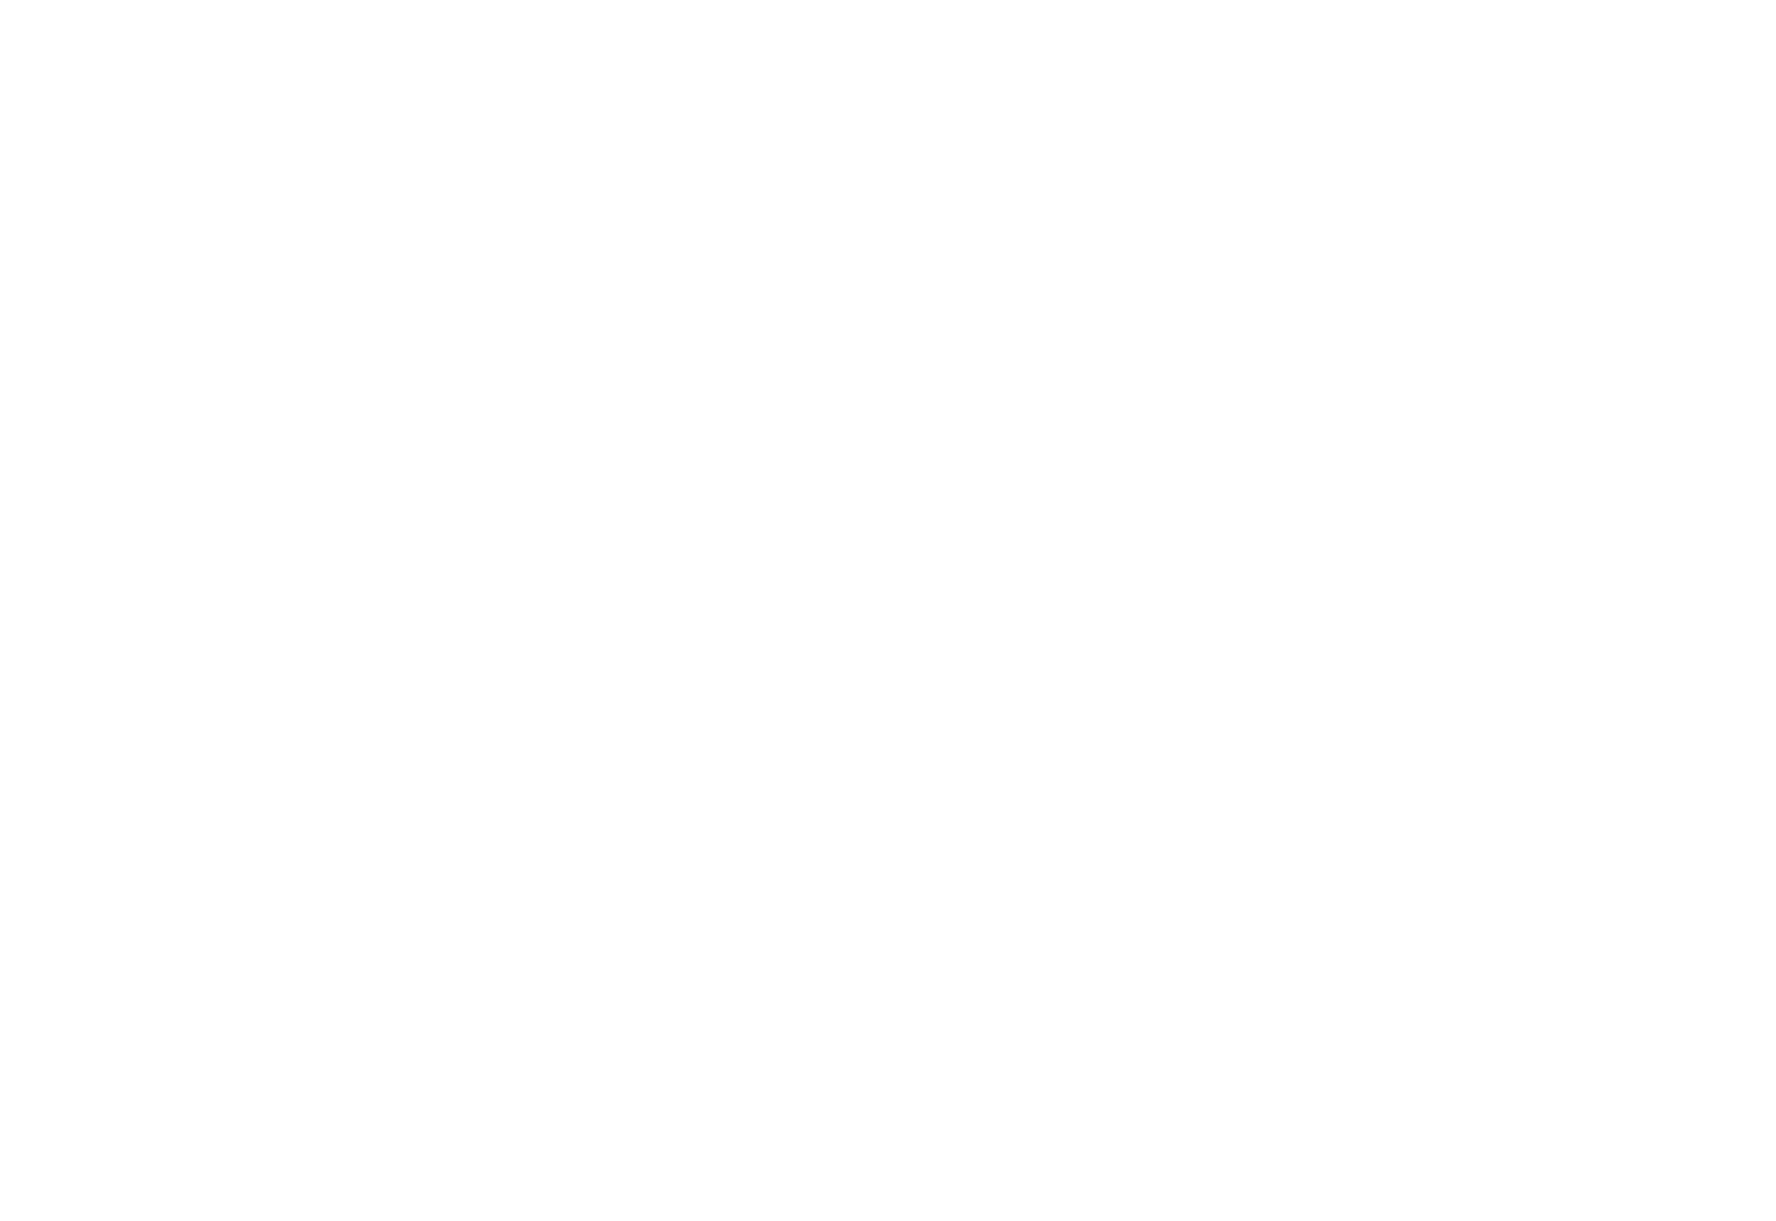

In [14]:
p_3_all_orbits = orbits_finder(df_01_p3)
p_6_all_orbits = orbits_finder(df_01_p6)
m_3_all_orbits = orbits_finder(df_01_m3)
m_6_all_orbits = orbits_finder(df_01_m6)
m_9_all_orbits = orbits_finder(df_01_m9)
p_0_all_orbits = orbits_finder(df_01)

        
plt.figure()
plt.title("Comparing Stripes of FUV Data for Orbit 0 on Jan 1st, 2020")
plt.plot(single_orb(p_0_all_orbits,1)[0],single_orb(p_0_all_orbits,1)[1],marker = '.', label = 'PO')
plt.plot(single_orb(p_3_all_orbits,1)[0],single_orb(p_3_all_orbits,1)[1],marker = '.', label = 'P3')
plt.plot(single_orb(p_6_all_orbits,1)[0],single_orb(p_6_all_orbits,1)[1],marker = '.', label = 'P6')
plt.plot(single_orb(m_3_all_orbits,1)[0],single_orb(m_3_all_orbits,1)[1],marker = '.', label = 'M3')
plt.plot(single_orb(m_6_all_orbits,1)[0],single_orb(m_6_all_orbits,1)[1],marker = '.', label = 'M6')
plt.plot(single_orb(m_9_all_orbits,1)[0],single_orb(m_9_all_orbits,1)[1],marker = '.', label = 'M9')


plt.legend()
plt.show()

## FUV FILTERING PLOTS

In [18]:
def corr_fuvs_and_fuvs(orbit1_data, orbit2_data, label1, label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    
 
    (fig, (ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize = (10,15))

    # FUV 1
    vm = abs(orbit1_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    pcm_1 = ax1.pcolormesh(pd.to_datetime(orbit1_data.time.values), orbit1_data.row, orbit1_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    ax1.set_ylabel('row')
    fig.colorbar(pcm_1, ax = ax1, label='R')
    ax1.set_title('FUV 1356 brightness of Stripe %s' %(label1))
    #ax1.set_xticklabels(pd.to_datetime(orbit1_data.time.values), rotation=45)

    #plt.gca().autofmt_xdate()
    
    # FUV 2
    vm = abs(orbit2_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    pcm_2 = ax2.pcolormesh(pd.to_datetime(orbit2_data.time.values), orbit2_data.row, orbit2_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    ax2.set_ylabel('row')
    #ax2.colorbar(label='R')
    fig.colorbar(pcm_2, ax = ax2, label='R')
    ax2.set_title('FUV 1356 brightness of Stripe %s' %(label2))
    
    #plt.gca().autofmt_xdate()    
    #ax2.set_xticklabels(pd.to_datetime(orbit1_data.time.values), rotation=45)

    plt.tight_layout()
    
    #fuv_plots_smoothed(orbit1_data)
    #fuv_plots_smoothed(orbit2_data)
    
    row_means_1 = orbit1_data.mean(dim = 'row')
    row_means_2 = orbit2_data.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1)
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 
    V12 = np.fft.fft(v1["I_1356_filt"]) * np.conj(np.fft.fft(v2["I_1356_filt"]))


    #FFT NOT SHIFTED
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_vals)))
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    ax3.plot(taus, np.fft.ifft(V12) / SIZE, '.-r')
    ax3.set_title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    ax3.set_ylabel('Correlated Power')
    #plt.xlabel('Time [ns]')
    #plt.xlim(-100, 100)
    ax3.axvline(0)
    ax3.grid()
    plt.show()

<IPython.core.display.Javascript object>


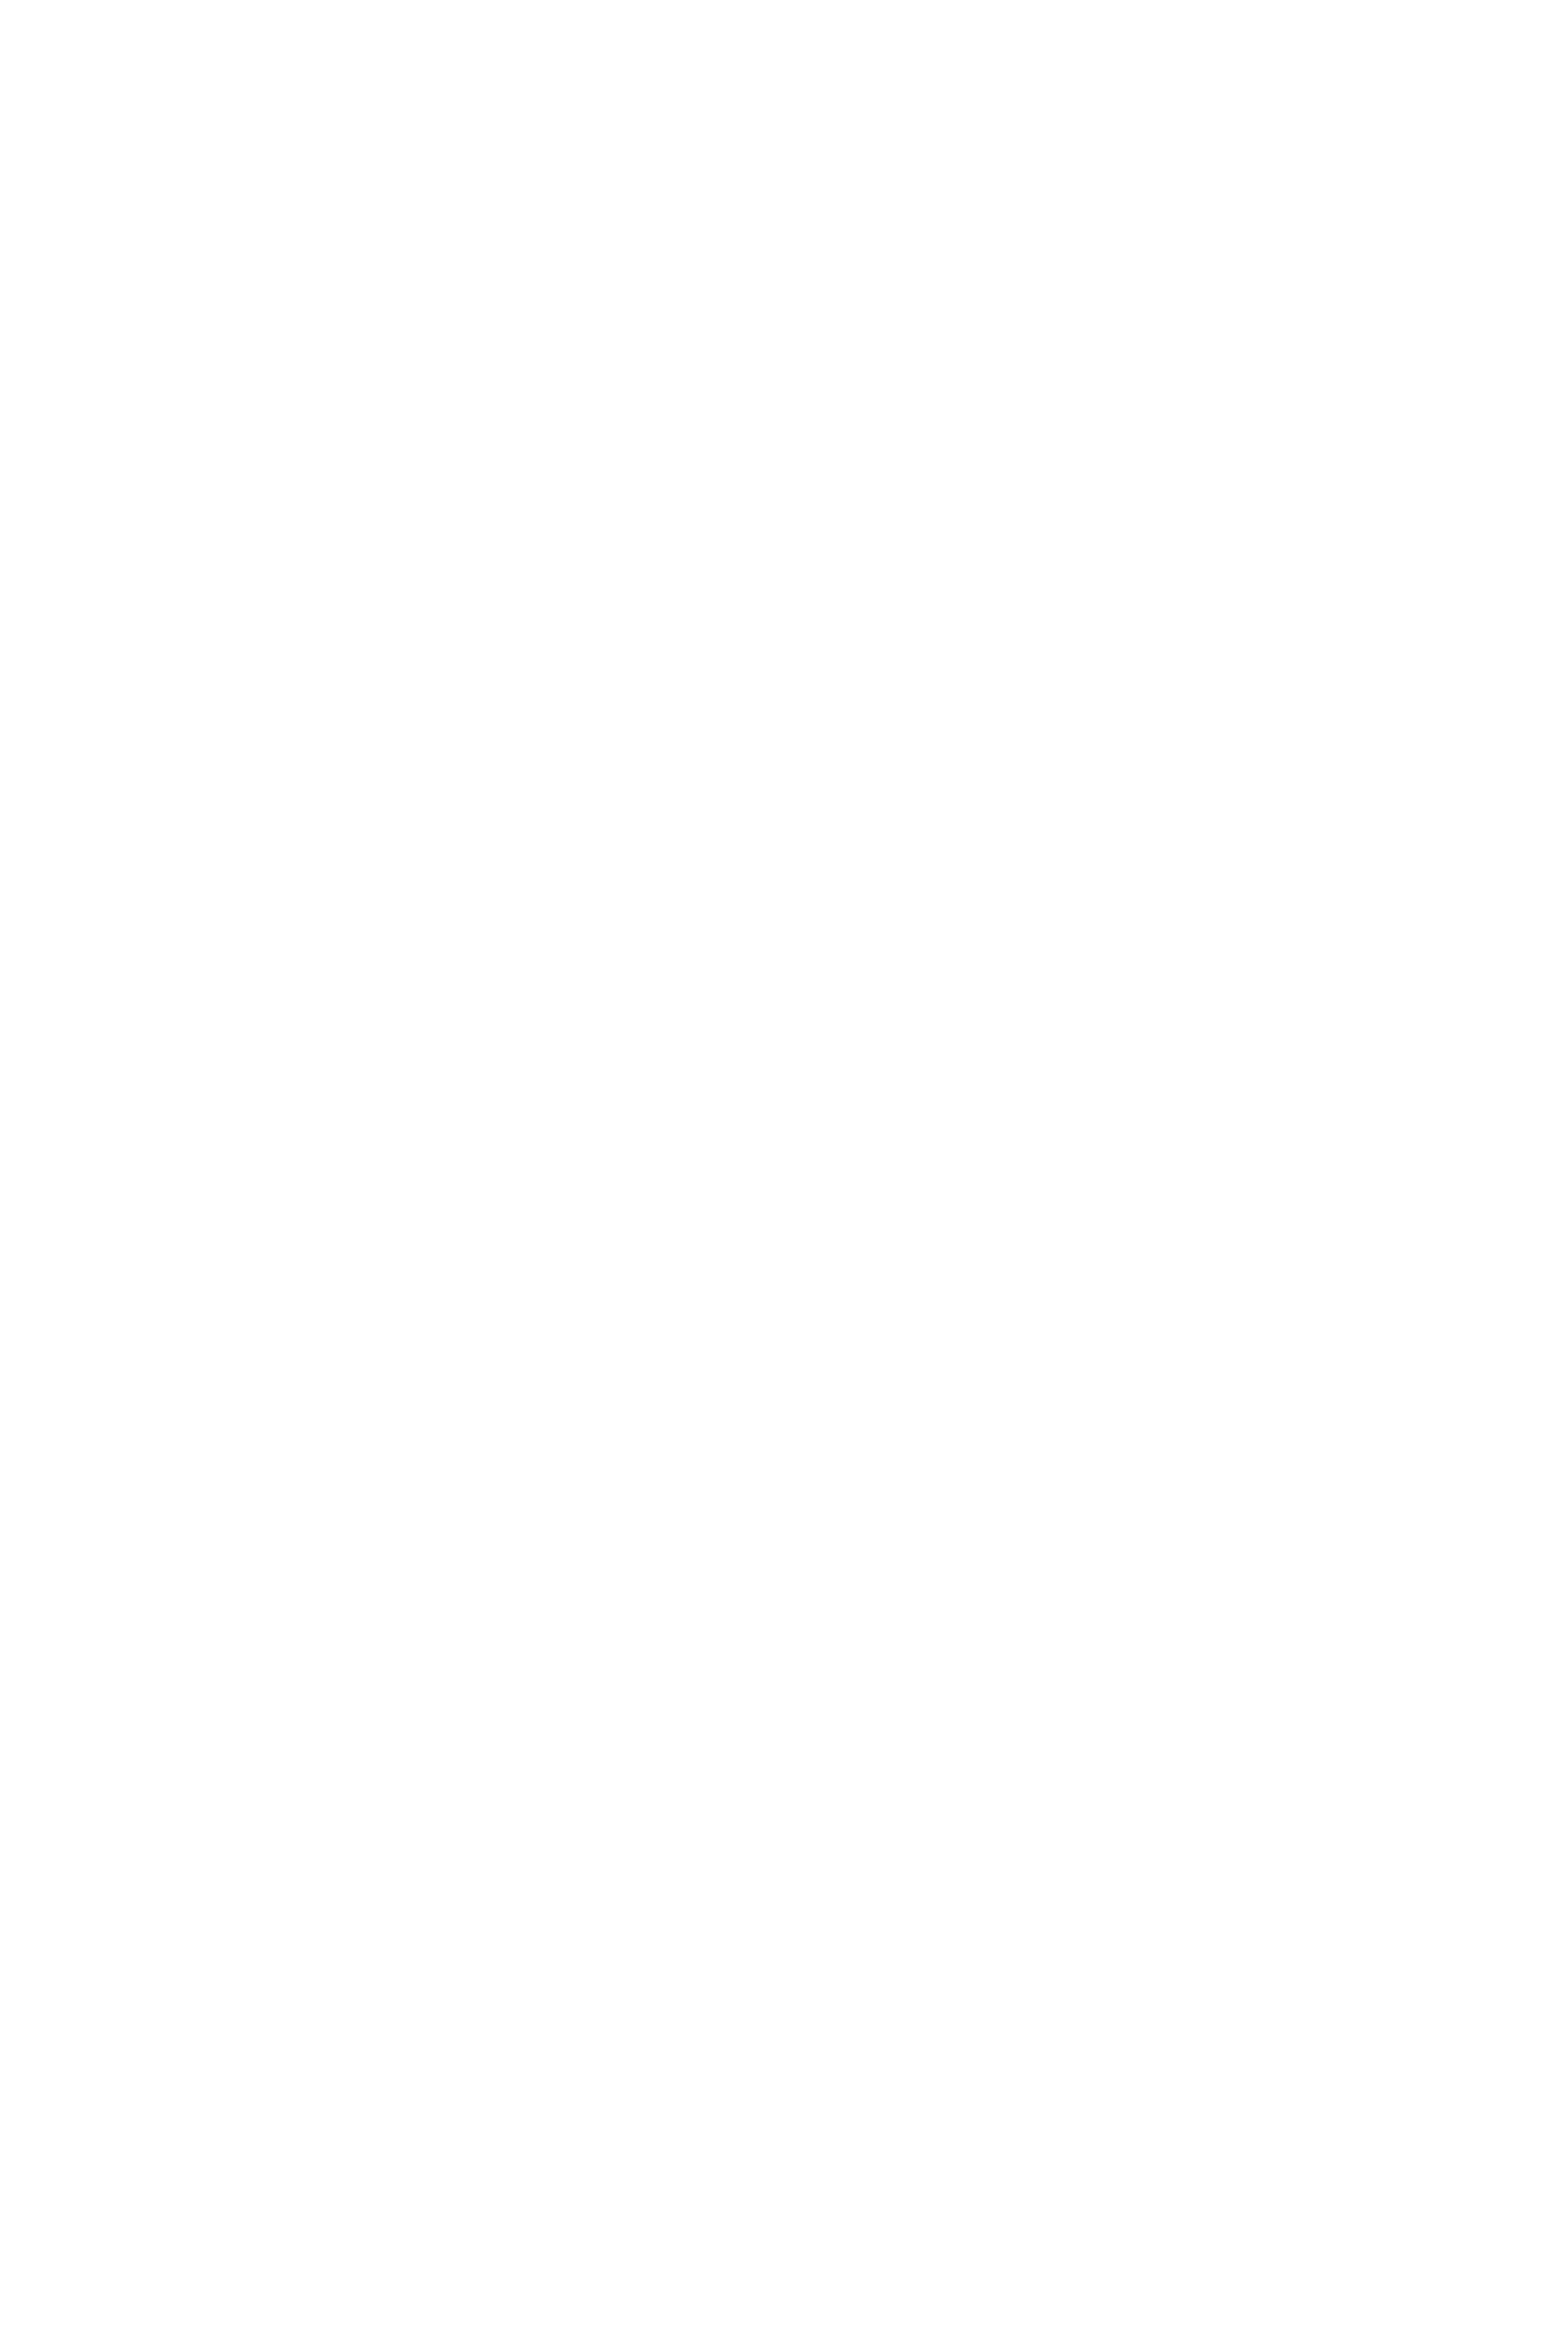

C:\Users\pkoll\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [19]:
corr_fuvs_and_fuvs(orbits_finder(orbits_finder(df_01_m6)[0])[0], orbits_finder(orbits_finder(df_01)[0])[0], "M6", "P0")

### INTERPOLATION AND FFT SHIFT

In [56]:
m3 = orbits_finder(orbits_finder(df_01_m3)[0])[0]
m3_label = 'M3'
m6 = orbits_finder(orbits_finder(df_01_m6)[0])[0]
m6_label = 'M6'
m9 = orbits_finder(orbits_finder(df_01_m9)[0])[0]
m9_label = 'M9'


p0 = orbits_finder(orbits_finder(df_01)[0])[0]
p0_label = 'P0'
p3 = orbits_finder(orbits_finder(df_01_p3)[0])[0]
p3_label = 'P3'
p6 = orbits_finder(orbits_finder(df_01_p6)[0])[0]
p6_label = 'P6'


In [57]:
def correlations_interpolated(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp)))
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) #sanity check this 
    taus_shifted = np.fft.fftshift(taus)
    
    #MAX and OFFSET
    max_index = np.argmax(np.abs(V12_shifted)) # check this with the shifted and the unshifted 
    print('index',max_index)
    
    # Calculate difference from 0
    max_difference = taus_shifted[max_index] - 0
    print('xval',taus_shifted[max_index])
    print("Difference from 0:", max_difference*1e-9)
    #print()



    # PLOT
    plt.figure()
    plt.plot(taus_shifted, V12_shifted, '.-r')
    plt.plot(taus_shifted[max_index], V12_shifted[max_index], 'bo', markersize=4)  # Emphasize max point
    plt.title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    plt.ylabel('Correlated Power')
    #plt.xlabel('Time [ns]')
    #plt.xlim(-100, 100)
    plt.axvline(0)
    plt.grid()
    plt.show()


In [58]:
def UNSHIFTED_corrs(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])

    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp)))
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])


    # #FFT SHIFT
    # V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE)
    # taus_shifted = np.fft.fftshift(taus)

    #MAX and OFFSET
    max_index = np.argmax(np.abs(np.fft.ifft(V12) / SIZE))
    print('index',max_index)
    
    # Calculate difference from 0
    max_difference = taus[max_index] - 0
    print('xval',taus[max_index])
    print("Difference from 0:", max_difference*1e-9)
    #print()


    # PLOT
    plt.figure()
    plt.plot(taus, np.fft.ifft(V12) / SIZE, '.-r')
    plt.title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    plt.ylabel('Correlated Power')
    #plt.xlabel('Time [ns]')
    #plt.xlim(-100, 100)
    plt.axvline(0)
    plt.grid()
    plt.show()

In [64]:
def differences(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp)))
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)
    
    #print('CORRELATION OF:',label1,label2)
    
    #MAX and OFFSET
    max_index = np.argmax(np.abs(V12_shifted)) 
    #print('Index:',max_index)
    
    # Calculate difference from 0
    max_difference = (taus_shifted[max_index] - 0)*1e-9
    #print('X Val (Tau):',taus_shifted[max_index])
    #print("Difference from 0:", max_difference*1e-9)
    
    return label1,label2,max_difference
    #print()

#### SHIFTED VS UNSHIFTED FOR MAX

index 53025
xval 304601600.0
Difference from 0: 0.30460160000000003


<IPython.core.display.Javascript object>


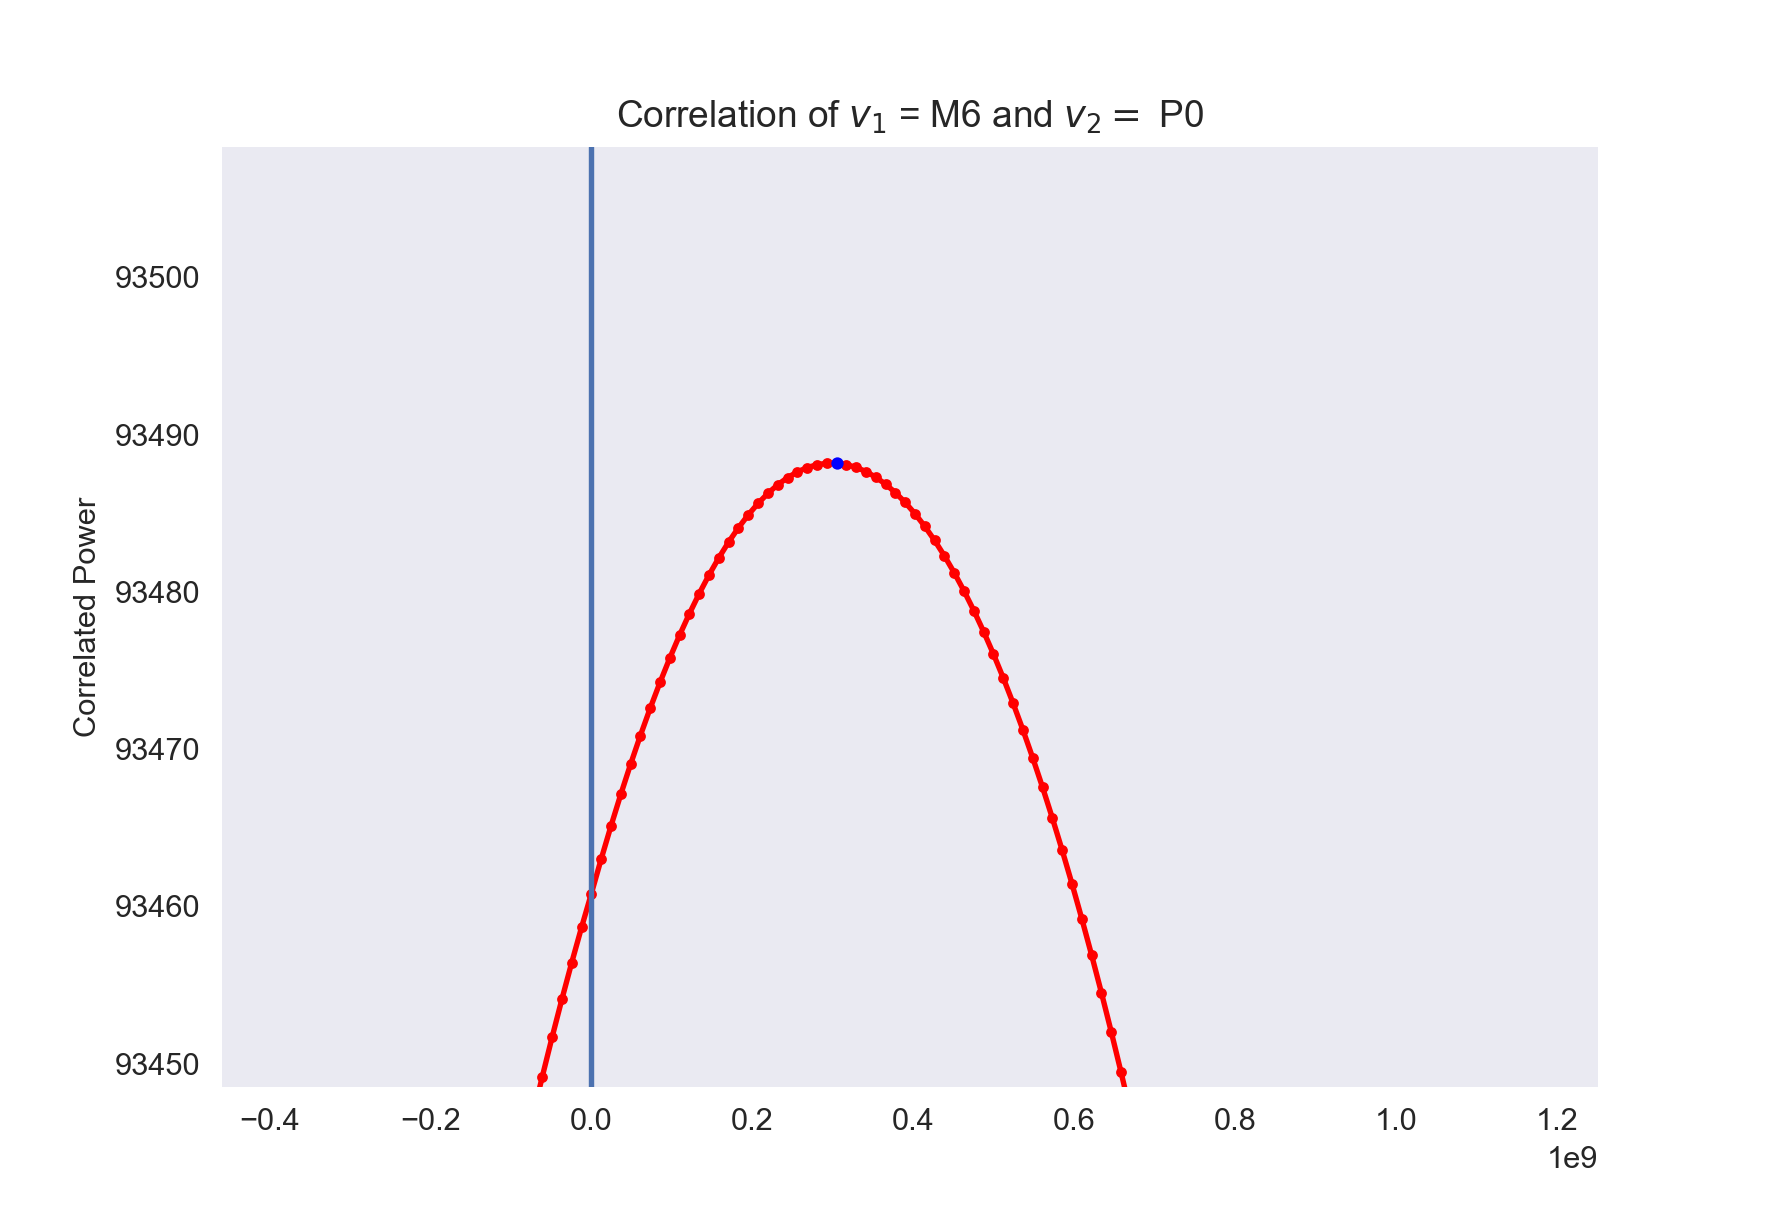

C:\Users\pkoll\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [62]:
correlations_interpolated(m6,p0,m6_label,p0_label)

index 25
xval 304601600.0
Difference from 0: 0.30460160000000003


<IPython.core.display.Javascript object>


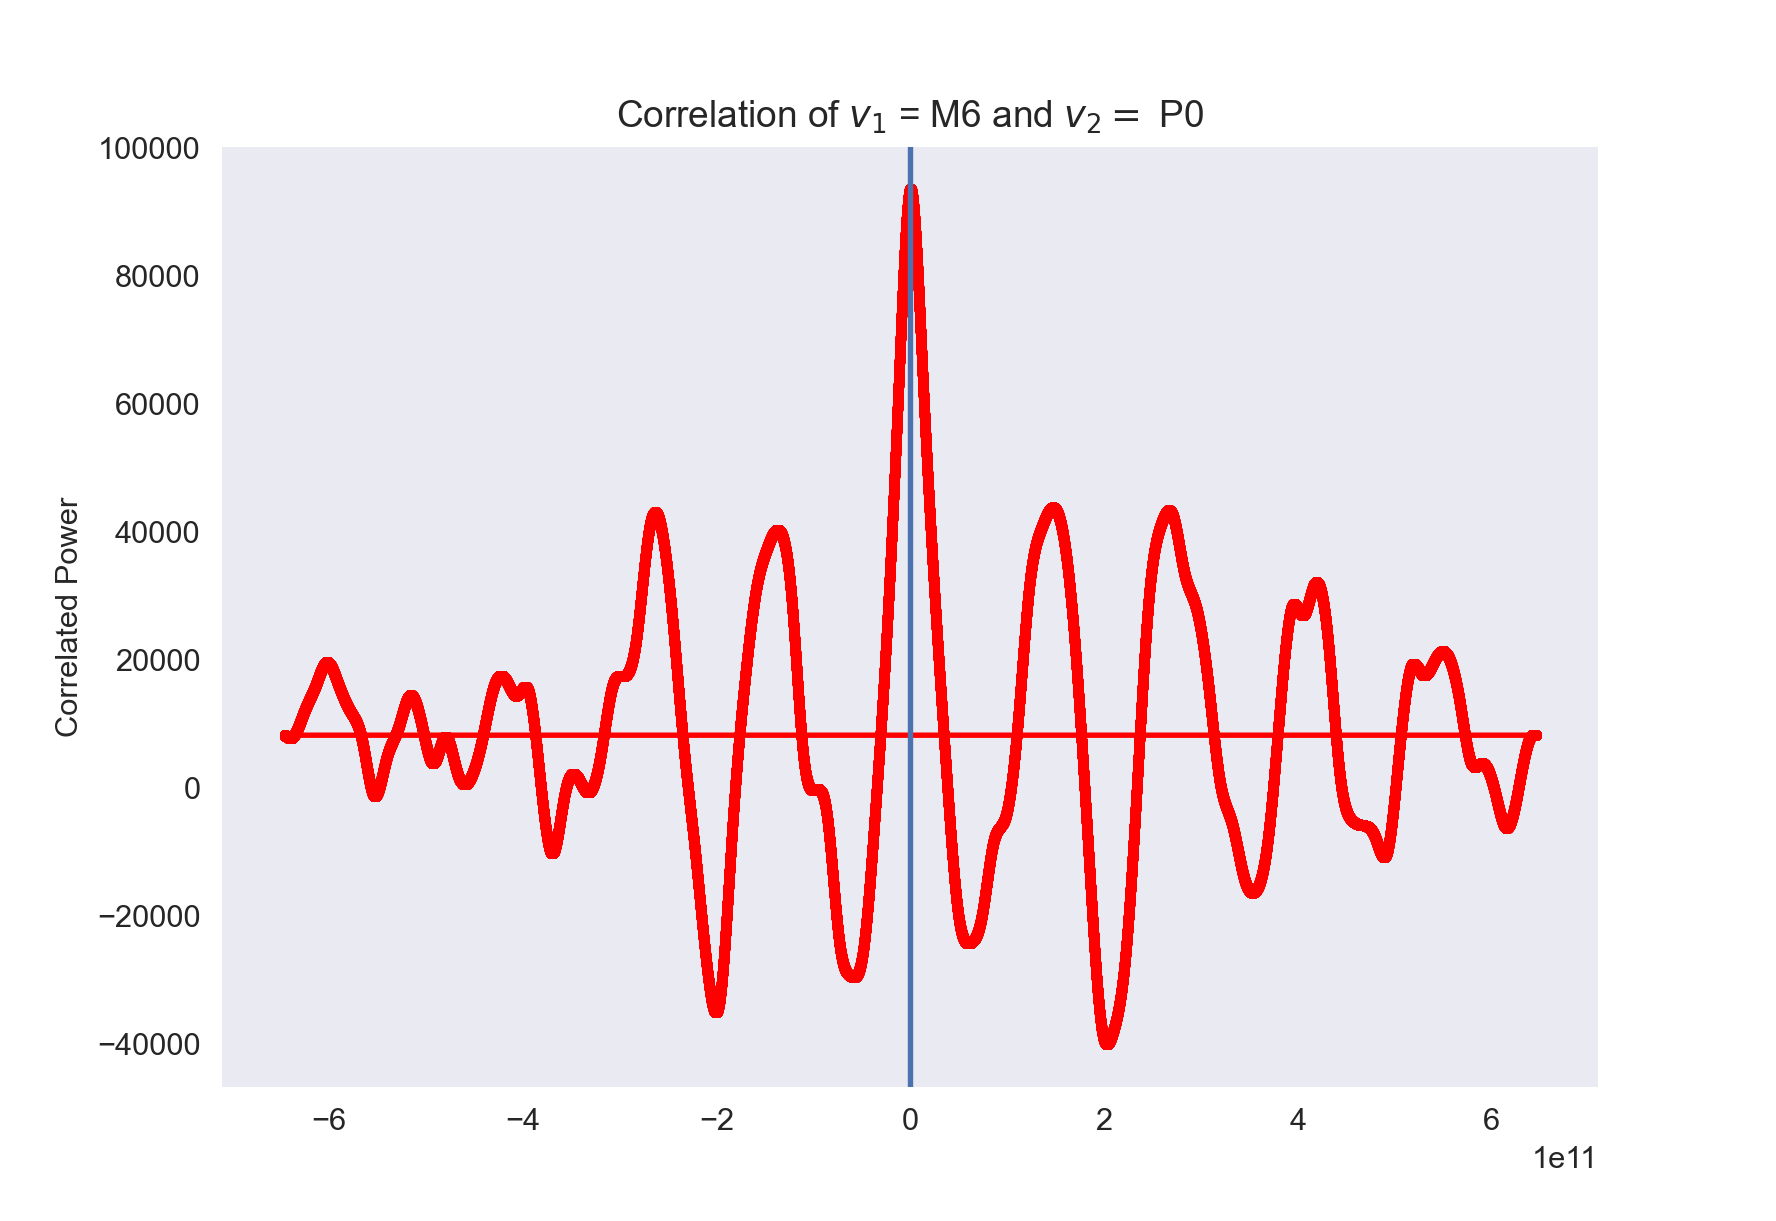

C:\Users\pkoll\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [63]:
UNSHIFTED_corrs(m6,p0,m6_label,p0_label)

#### ANGLE VS DIFFERENCE PLOT


In [67]:
all_orbs = [m9,m6,m3,p0,p3,p6]
all_labels = [m9_label,m6_label,m3_label,p0_label,p3_label,p6_label]


first = []
second = []
diffs = []

for orbit1_idx in range(0,len(all_orbs)):
    for orbit2_idx in range(0,len(all_orbs)):
        diff = differences(all_orbs[orbit1_idx],all_orbs[orbit2_idx],all_labels[orbit1_idx],all_labels[orbit2_idx])
        first.append(diff[0])
        second.append(diff[1])
        diffs.append(diff[2])

In [163]:
d = {'First': first,'Second':second,'Difference':diffs}

angle_offsets = pd.DataFrame(data=d)

# FIRST
angle_offsets['First Angle'] = angle_offsets['First'].str.extract('(\d+)').astype(int)
angle_offsets['First Angle'] = angle_offsets.apply(
    lambda row: -row['First Angle'] if row['First'].startswith('M') else row['First Angle'], axis=1
)

# SECOND

angle_offsets['Second Angle'] = angle_offsets['Second'].str.extract('(\d+)').astype(int)
angle_offsets['Second Angle'] = angle_offsets.apply(
    lambda row: -row['Second Angle'] if row['Second'].startswith('M') else row['Second Angle'], axis=1
)


angle_offsets['Angle Diff'] = (angle_offsets['Second Angle']- angle_offsets['First Angle'])
angle_offsets['Absolute Time Difference'] = angle_offsets['Difference'].apply(abs)

angle_offsets

,First,Second,Difference,First Angle,Second Angle,Angle Diff,Absolute Time Difference
0,M9,M9,0.000000,-9,-9,0,0.000000
1,M9,M6,0.414258,-9,-6,3,0.414258
2,M9,M3,0.865069,-9,-3,6,0.865069
3,M9,P0,0.353338,-9,0,9,0.353338
4,M9,P3,0.682308,-9,3,12,0.682308
5,M9,P6,0.889437,-9,6,15,0.889437
6,M6,M9,-0.414258,-6,-9,-3,0.414258
7,M6,M6,0.000000,-6,-6,0,0.000000
8,M6,M3,0.426442,-6,-3,3,0.426442
9,M6,P0,0.304602,-6,0,6,0.304602


In [150]:
def best_fit(m,x,b):
    return (m*x)

<IPython.core.display.Javascript object>


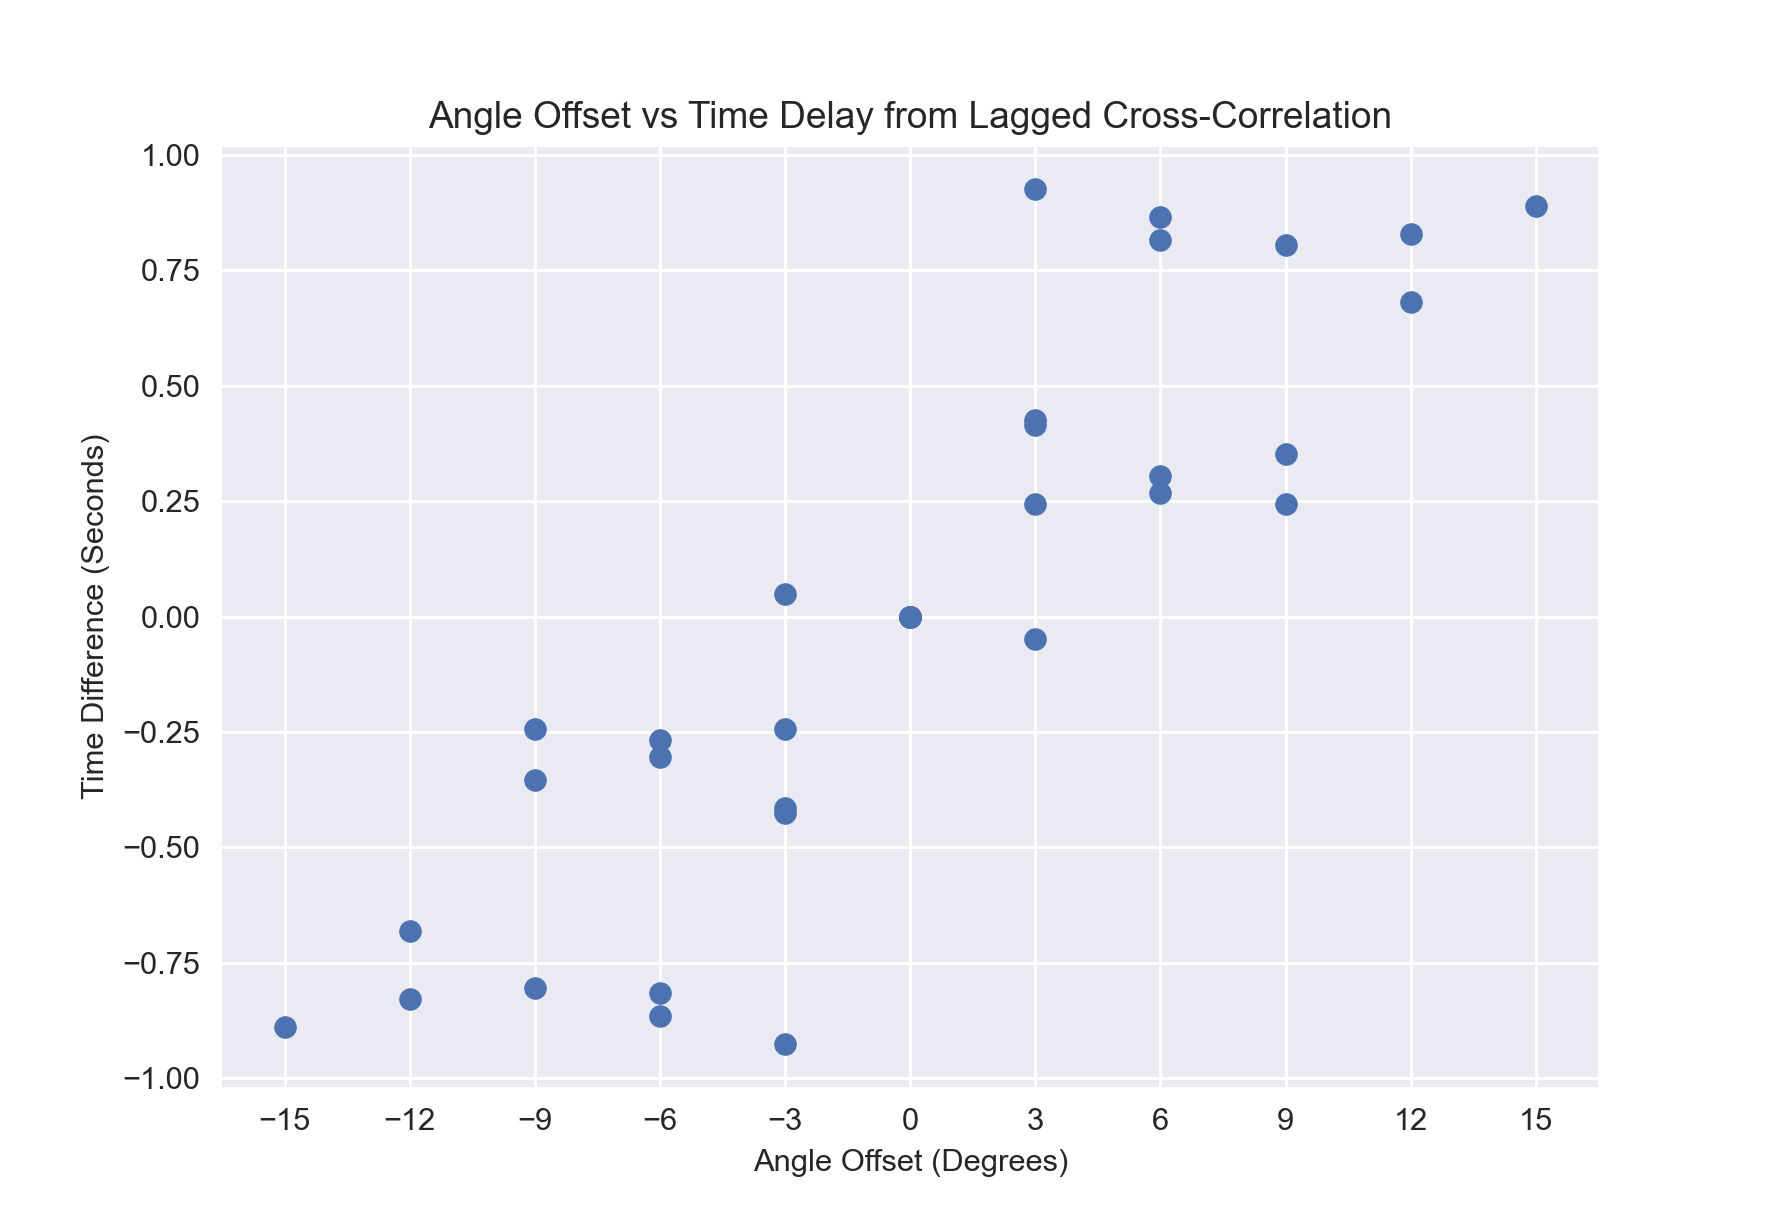

In [164]:
plt.figure()
plt.title("Angle Offset vs Time Delay from Lagged Cross-Correlation")
plt.xlabel("Angle Offset (Degrees)")
plt.ylabel("Time Difference (Seconds)")
plt.scatter(angle_offsets['Angle Diff'],angle_offsets['Difference'])
plt.xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])
plt.show()

In [165]:
x = [-15,-12,-9,-6,-3,0,3,6,9,12,15]
y_7 = [-35,-28,-21,-14,-7,0,7,14,21,28,35]
y_16 = [-96,-80,-48,-32,-16,0,16,32,48,80,96]

dict_x = {'X': x,'Slope 7':y_7,'Slope 16':y_16}
lines = pd.DataFrame(data=dict_x)


<IPython.core.display.Javascript object>


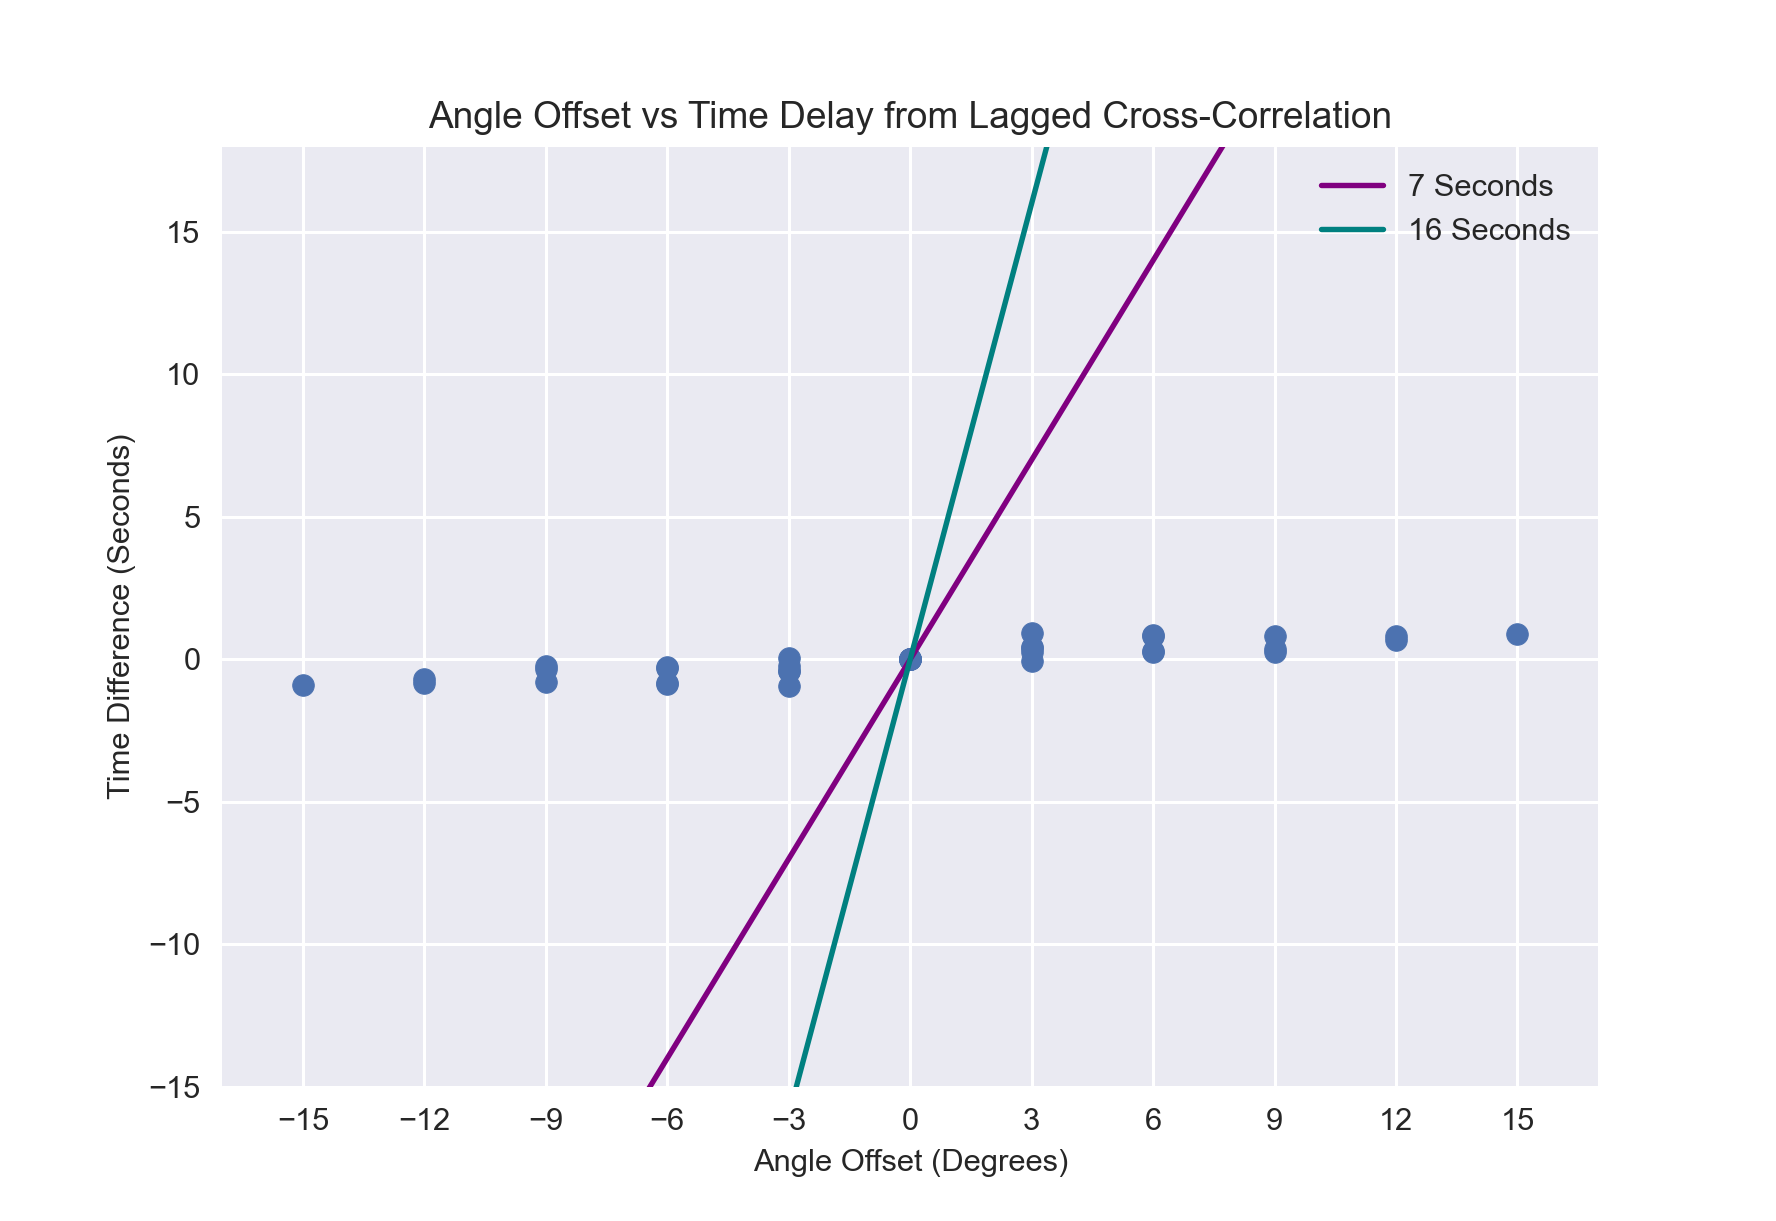

In [166]:
plt.figure()
plt.title("Angle Offset vs Time Delay from Lagged Cross-Correlation")
plt.xlabel("Angle Offset (Degrees)")
plt.ylabel("Time Difference (Seconds)")
plt.scatter(angle_offsets['Angle Diff'],angle_offsets['Difference'] )
plt.plot(x, lines['Slope 7'],color = 'purple', label = '7 Seconds') 
plt.plot(x, lines['Slope 16'],color ='teal', label = '16 Seconds') 
plt.xlim(-17,17)
plt.ylim(-15,18)

plt.xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])
plt.legend()
plt.show()

In [125]:
best_fit(7,x,0)

array([-63, -42, -21,   0,  21,  42])

In [126]:
x

array([-9, -6, -3,  0,  3,  6])

<IPython.core.display.Javascript object>


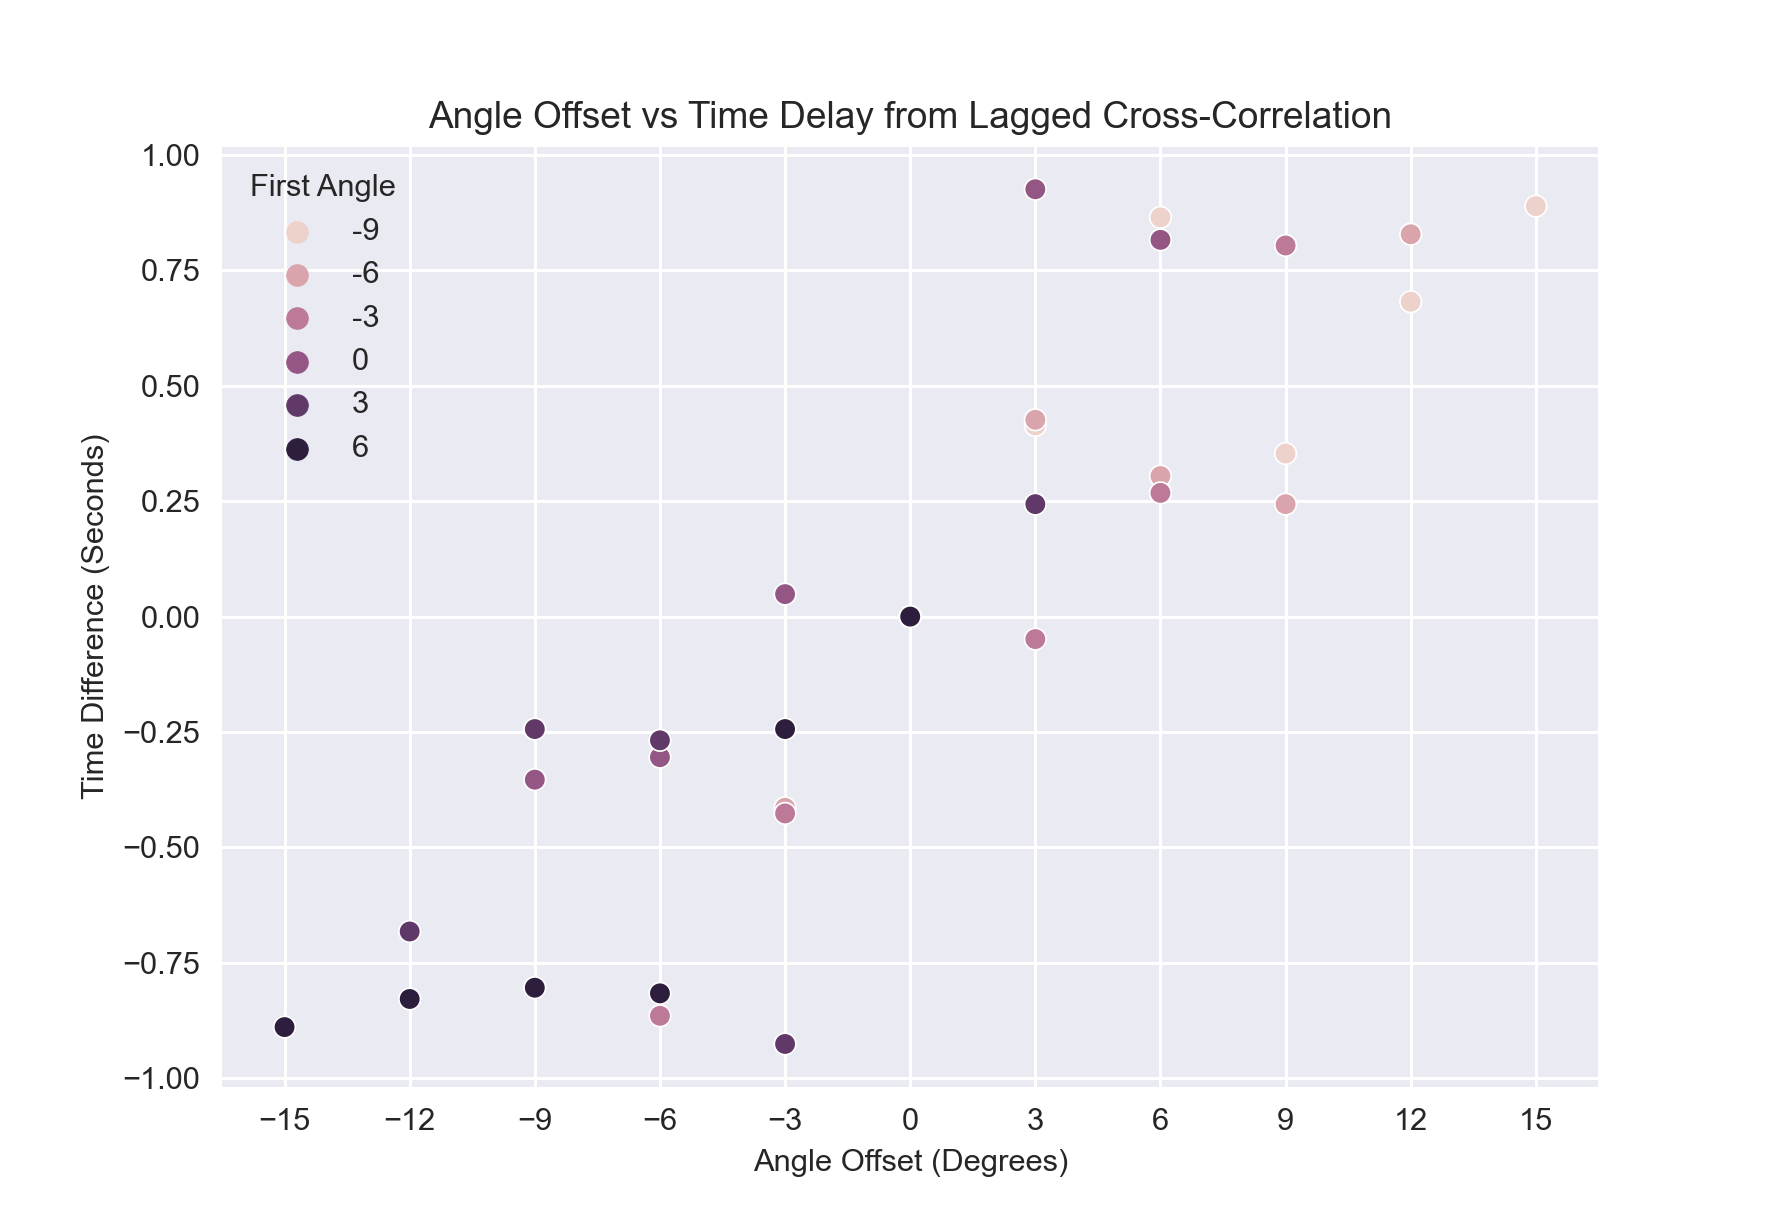

In [168]:
plt.figure()
plt.title("Angle Offset vs Time Delay from Lagged Cross-Correlation")
plt.xlabel("Angle Offset (Degrees)")
plt.ylabel("Time Difference (Seconds)")
sns.scatterplot(data = angle_offsets, x = angle_offsets['Angle Diff'],y = angle_offsets['Difference'], hue = angle_offsets['First Angle'])
plt.xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])

#plt.ylim(0,10)
#plt.axhline(0)
plt.show()

### IS THIS OFFSET SLOPE POSITIVE OR NEGATIVE?

<IPython.core.display.Javascript object>


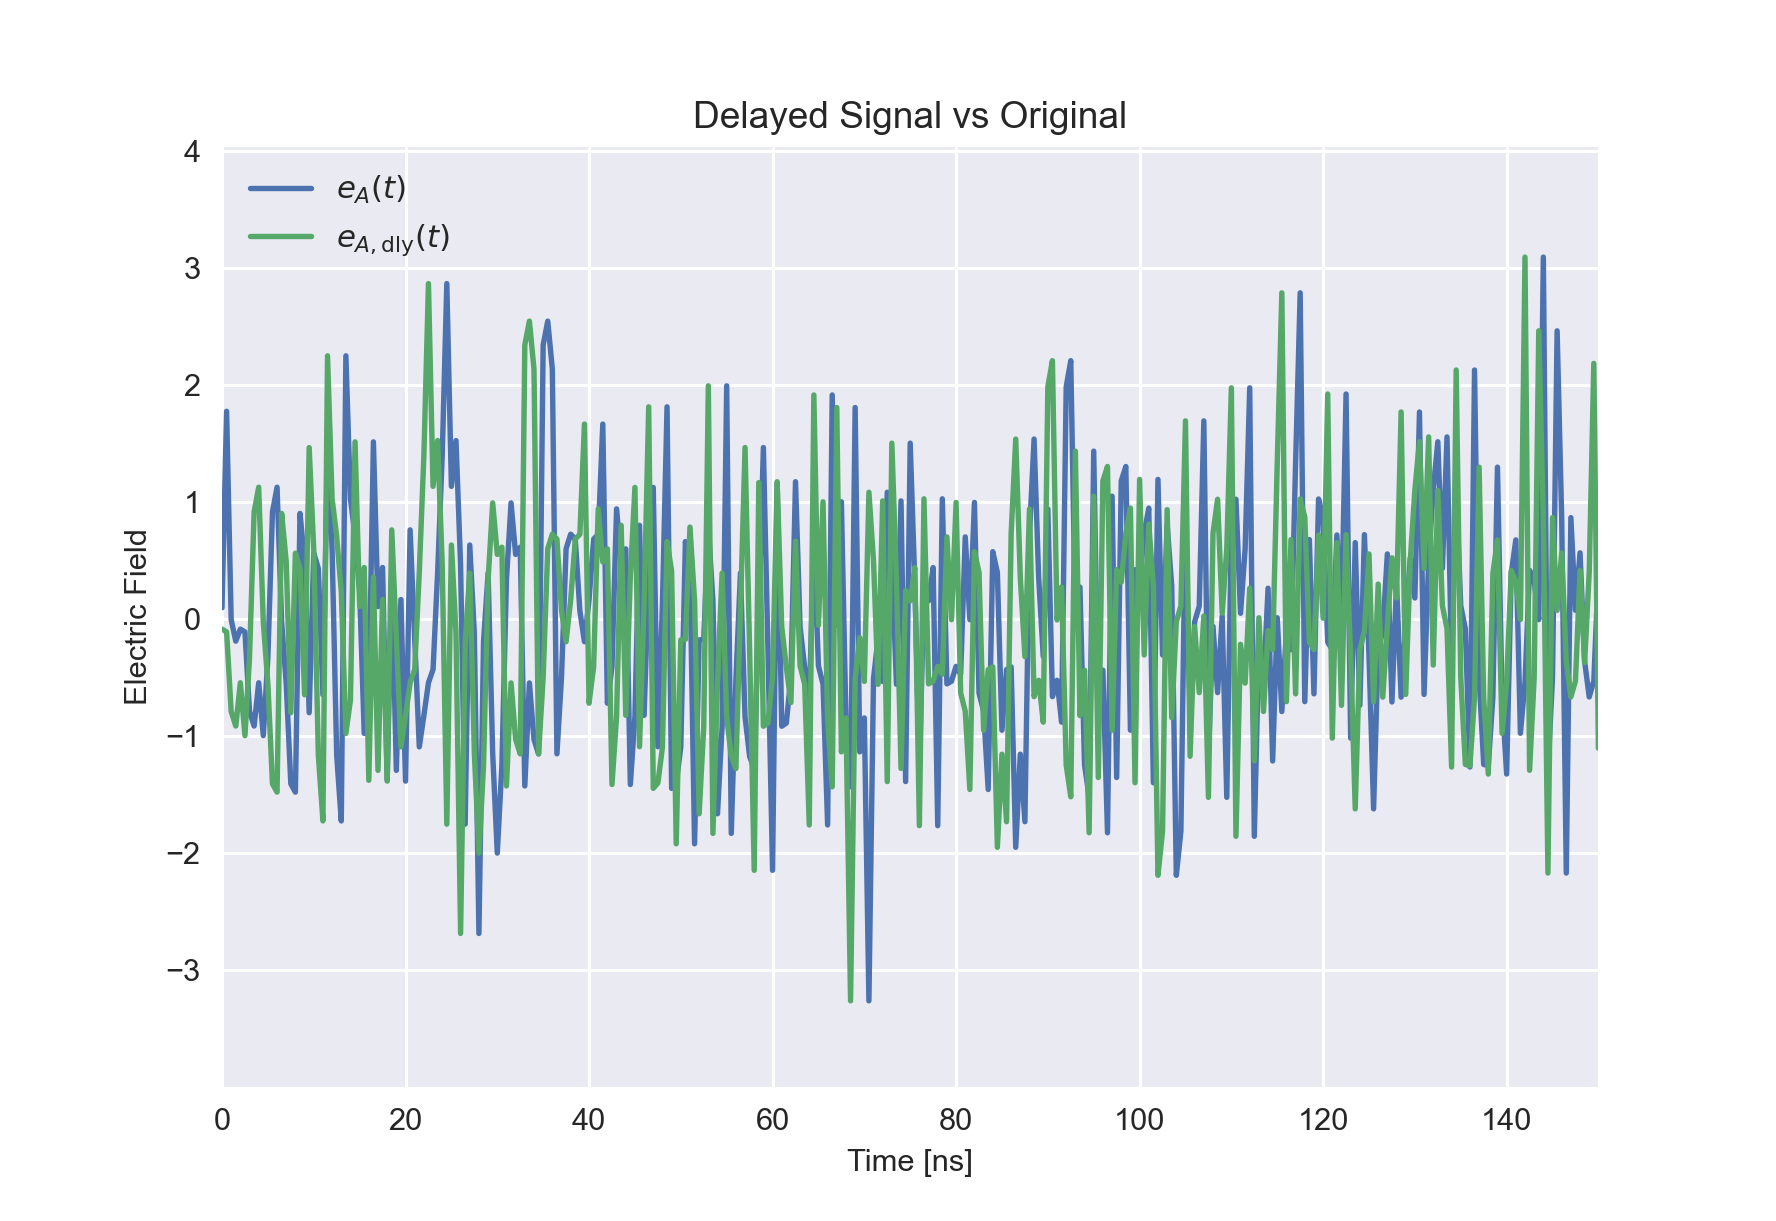

In [169]:
## TEST DATA

SIZE = 10000
t = np.arange(SIZE) * 0.5e-9 # time step of 0.5 us = 1/(2 MHz)
e_A = np.random.normal(size=SIZE)
e_B = 0.5 * np.random.normal(size=SIZE)


fqs = np.fft.fftfreq(t.size, np.median(np.diff(t)))
tau_A = 2e-9
tau_B = -30e-9
# Using the convolution theorem to introduce a geometric delay- OFFSET TO LEFT
e_A_dly = np.fft.ifft(np.fft.fft(e_A) * np.exp(2j*np.pi*tau_A*fqs)).real
e_B_dly = np.fft.ifft(np.fft.fft(e_B) * np.exp(2j*np.pi*tau_B*fqs)).real

v1 = e_A_dly 
v2 = e_A

plt.figure()
plt.plot(t * 1e9, e_A, label=r"$e_A(t)$")
plt.plot(t * 1e9, e_A_dly, label=r"$e_{A,{\rm dly}}(t)$")
plt.title("Delayed Signal vs Original")
plt.ylabel('Electric Field')
plt.xlabel('Time [ns]')
plt.xlim(0,150)
_ = plt.legend()
plt.show()